In [1]:
import os
import ast
import wfdb
import numpy as np
import pandas as pd

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'subdiagnostic'
experiment_name = 'exp1.1'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

This experiment has 23 classes


In [5]:
X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

In [6]:
import tensorflow as tf

def batch_norm():
    return tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)


def relu():
    return tf.keras.layers.ReLU()

def dropout(dp=0):
    return tf.keras.layers.Dropout(dp)

def conv1d(filters, kernel_size=3, strides=1):
    return tf.keras.layers.Conv1D(
        filters, kernel_size, strides=strides, padding='same', use_bias=False,
        kernel_initializer=tf.keras.initializers.VarianceScaling())


In [7]:
# Residual block function
def residual_block(x, filters, kernel_size=3, strides=1, dp=0):
    num_chan = 1000
    shortcut = x
    x = conv1d(filters, kernel_size, strides)(x)
    x = batch_norm()(x)
    x = relu()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = conv1d(filters, kernel_size, 1)(x)
    x = batch_norm()(x)
    x = relu()(x)
    
    if num_chan != filters or strides>1:
        proj_conv = conv1d(filters, 1, strides)(shortcut)
        proj_bn = batch_norm()(proj_conv)
    
    out = tf.keras.layers.Add()([x, proj_bn])
    out = tf.keras.layers.Activation('relu')(out)
    return out
    

In [8]:
blocks = [1,1]
filters = [32, 64]
kernel_size = [15,15]
dp=0.1

In [9]:
input_layer = tf.keras.layers.Input(shape=(1000,1))

x = conv1d(64, 7, 2)(input_layer)
x = batch_norm()(x)
x = relu()(x)
x = tf.keras.layers.MaxPooling1D(3, 2, padding='same')(x)
for stage, num_blocks in enumerate(blocks):
    for block in range(num_blocks):
        strides=2 if block==0 and stage>0 else 1
        x = residual_block(x, filters[stage], kernel_size[stage], strides, dropout)
    
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(23, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=outputs)

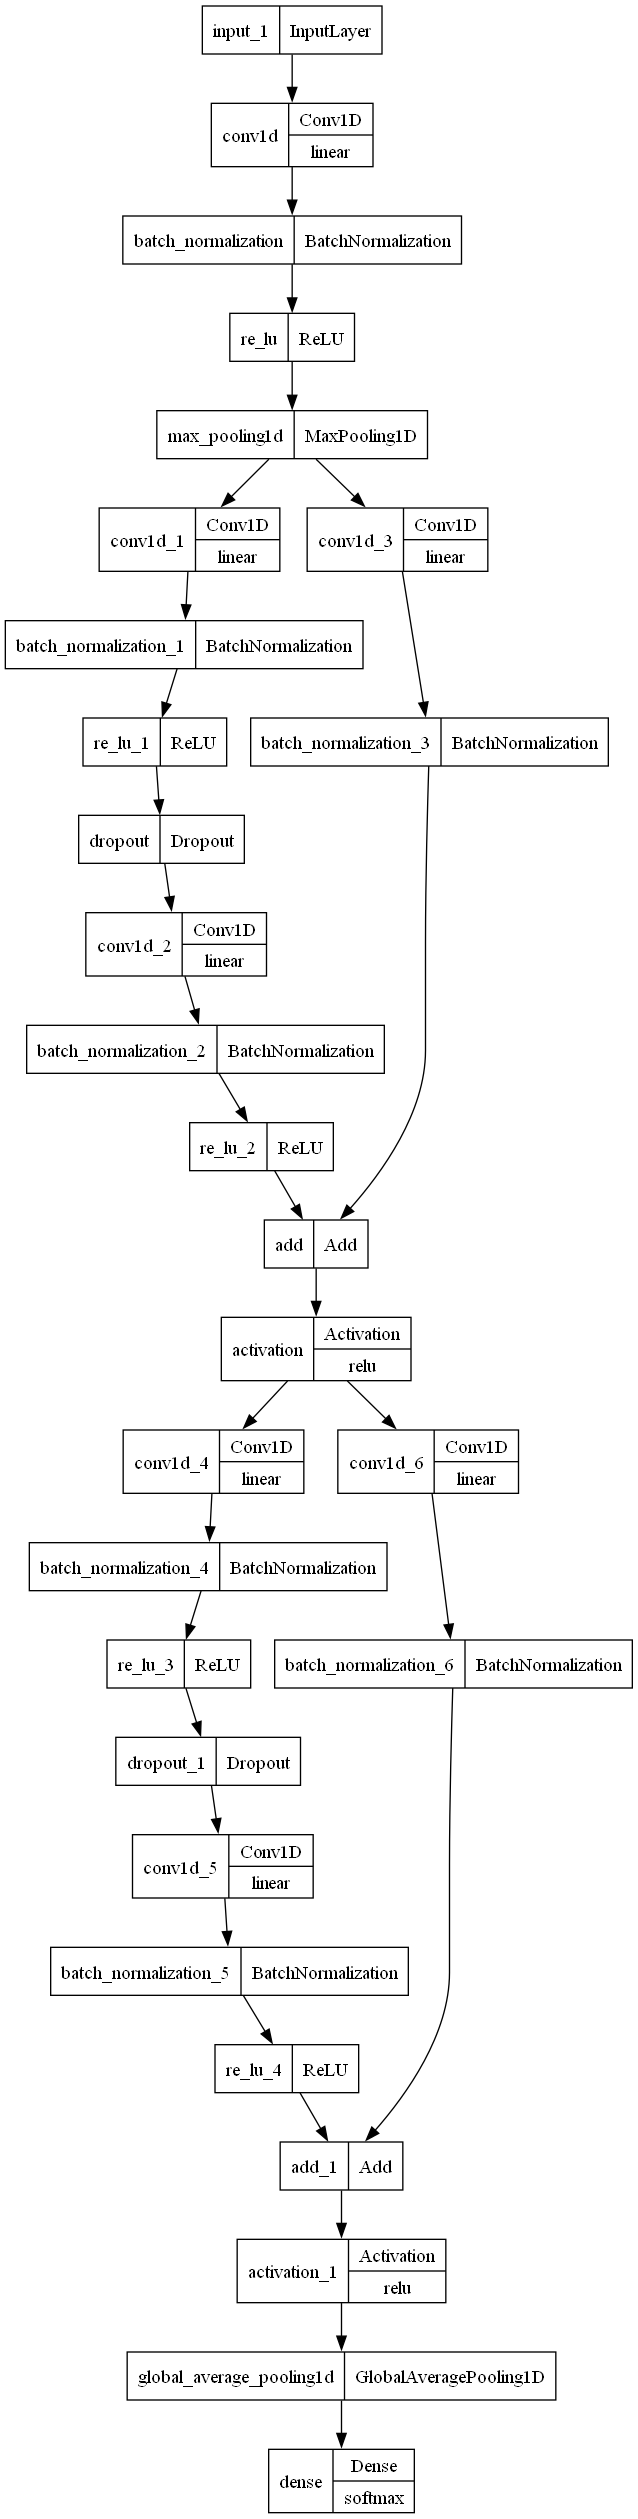

In [10]:
from keras.utils import plot_model
plot_model(model, show_layer_activations=True)

In [11]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)])

model.fit(X_train_lead1, y_train, validation_data=(X_val_lead1, y_val), batch_size=32, epochs=20)

Epoch 1/20
534/534 [==============================] - 92s 164ms/step - loss: 0.1514 - accuracy: 0.9484 - recall: 0.2670 - AUC: 0.7343 - val_loss: 0.1462 - val_accuracy: 0.9494 - val_recall: 0.2341 - val_AUC: 0.7614
Epoch 2/20
534/534 [==============================] - 90s 169ms/step - loss: 0.1398 - accuracy: 0.9499 - recall: 0.2913 - AUC: 0.7717 - val_loss: 0.1403 - val_accuracy: 0.9504 - val_recall: 0.3172 - val_AUC: 0.7568
Epoch 3/20
534/534 [==============================] - 88s 166ms/step - loss: 0.1363 - accuracy: 0.9505 - recall: 0.2983 - AUC: 0.7853 - val_loss: 0.1376 - val_accuracy: 0.9507 - val_recall: 0.3219 - val_AUC: 0.7671
Epoch 4/20
534/534 [==============================] - 94s 176ms/step - loss: 0.1337 - accuracy: 0.9509 - recall: 0.3052 - AUC: 0.7930 - val_loss: 0.1413 - val_accuracy: 0.9498 - val_recall: 0.2384 - val_AUC: 0.7832
Epoch 5/20
534/534 [==============================] - 93s 174ms/step - loss: 0.1317 - accuracy: 0.9513 - recall: 0.3094 - AUC: 0.8004 - val_

In [12]:
preds = model.predict(X_test_lead1)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, preds)

68/68 [==============================] - 2s 21ms/step


0.8331252180788822

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)])

model.fit(X_train_lead1, y_train, validation_data=(X_val_lead1, y_val), epochs=10)

Epoch 1/10
534/534 [==============================] - 51s 89ms/step - loss: 0.1106 - accuracy: 0.9548 - recall: 0.3670 - AUC: 0.8744 - val_loss: 0.1382 - val_accuracy: 0.9515 - val_recall: 0.3371 - val_AUC: 0.8045
Epoch 2/10
534/534 [==============================] - 51s 95ms/step - loss: 0.1088 - accuracy: 0.9553 - recall: 0.3740 - AUC: 0.8863 - val_loss: 0.1392 - val_accuracy: 0.9514 - val_recall: 0.3391 - val_AUC: 0.7771
Epoch 3/10
534/534 [==============================] - 47s 88ms/step - loss: 0.1074 - accuracy: 0.9555 - recall: 0.3759 - AUC: 0.8787 - val_loss: 0.1410 - val_accuracy: 0.9516 - val_recall: 0.3510 - val_AUC: 0.7708
Epoch 4/10
534/534 [==============================] - 50s 93ms/step - loss: 0.1056 - accuracy: 0.9560 - recall: 0.3850 - AUC: 0.8907 - val_loss: 0.1450 - val_accuracy: 0.9514 - val_recall: 0.3272 - val_AUC: 0.7631
Epoch 5/10
534/534 [==============================] - 49s 92ms/step - loss: 0.1035 - accuracy: 0.9563 - recall: 0.3885 - AUC: 0.8913 - val_loss:

In [14]:
preds = model.predict(X_test_lead1)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, preds)

68/68 [==============================] - 3s 41ms/step


0.7968666854745365